## ML-Tutorial for Kinase Activity Prediction 

This tutorial is adapted from [TeachOpenCADD](https://projects.volkamerlab.org/teachopencadd/talktorials/T022_ligand_based_screening_neural_network.html)


In [1]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

The next cell is used to define some important constants.

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Data preparation

Let's load the data which is a subset of ChEMBL for EGFR. The important columns in the dataframe are:

- CHEMBL-ID
- SMILES string of the corresponding compound
- Measured affinity: IC50

The next cell is used to load the dataset directly from the url.

In [3]:
url = "https://cloud-new.gdb.tools/index.php/s/ZfZM7itQf3rm6Sw/download"
df = pd.read_csv(url, index_col=0)
df = df.reset_index(drop=True)

Show basic information about the dataset.

In [4]:
# Check the dimension and missing value of the data
print("Shape of dataframe : ", df.shape)
df.info()

Shape of dataframe :  (179827, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179827 entries, 0 to 179826
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   molecule_chembl_id  179827 non-null  object 
 1   standard_value      179827 non-null  float64
 2   standard_units      179827 non-null  object 
 3   target_chembl_id    179827 non-null  object 
 4   smiles              179827 non-null  object 
dtypes: float64(1), object(4)
memory usage: 6.9+ MB


Next cell is used to look at the first few data entries.

In [5]:
# Look at head
df.head()

,molecule_chembl_id,standard_value,standard_units,target_chembl_id,smiles
0,CHEMBL13462,4000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
1,CHEMBL13462,16000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
2,CHEMBL13462,800.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
3,CHEMBL13462,9000.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
4,CHEMBL13462,1700.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...


Next cell is used to drop irrelevant columns and to calculate the pIC50 values.

In [6]:
# Keep necessary columns
chembl_df = df[["smiles", "target_chembl_id", "standard_value"]]

#calculate pIC50
chembl_df['standard_value'] = -np.log10(df['standard_value'] * 1e-9)
df.rename(columns={'standard_value': 'pIC50'}, inplace=True)

chembl_df.replace([np.inf, -np.inf], np.nan, inplace=True)
chembl_df.dropna(inplace=True)
chembl_df.head()


,smiles,target_chembl_id,standard_value
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,5.397940
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,4.795880
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,6.096910
3,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,5.045757
4,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,5.769551


**Molecular encoding**

We convert the SMILES string to numerical data to apply a neural network. We use the already defined function `smiles_to_fp` from **Talktorial T007** which generates fingerprints from SMILES.
The default encoding are MACCS keys with 166 bits (see **Talktorial T007** for more information on molecular encoding).

The next cell defines a function to convert the structure information to a binary array which can be used as input by the Keras model.

In [7]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

Convert all SMILES strings to MACCS fingerprints.

The next cell applies the function above and checks the first few datapoints.

In [8]:
#change canonical_smiles to smiles
chembl_df["SMILES_fingerprints"] = chembl_df["smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT

Shape of dataframe: (179154, 4)


,smiles,target_chembl_id,standard_value,SMILES_fingerprints
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,5.39794,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,4.79588,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,6.09691,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


The next cell defines a function to convert the target id of the kinase to a binary array.

In [9]:

def convert_target_id(chembl_code, input_length=25):
    """Converts a ChEMBL target id to a numpy array of fixed length that can be used as input the neural network"""
    
    # Remove the 'CHEMBL' prefix from the ChEMBL code
    code_integer = int(chembl_code.replace('CHEMBL', ''))
    
    # Convert the integer to a numpy array of fixed length
    
    binary_str = '{0:b}'.format(code_integer).zfill(input_length)
    input_array = np.array([float(bit) for bit in binary_str], dtype=np.float64)
    
    return input_array


The next cell applies the function above to the data and saves the ouput in a new column

In [13]:
chembl_df["chembl_id"] = chembl_df["target_chembl_id"].apply(convert_target_id)

chembl_df.head()

,smiles,target_chembl_id,standard_value,SMILES_fingerprints,binary_id,chembl_id
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,5.397940,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,4.795880,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,6.096910,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,5.045757,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,5.769551,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


The next cell creates a new column where the two binary arrays are combined into a single one.

In [15]:
### create a new column that combines the information from the target and the chemical structure in one array
chembl_df['combined_input'] = chembl_df.apply(lambda row: np.concatenate([row['SMILES_fingerprints'], row['chembl_id']]), axis=1)
chembl_df.head()

,smiles,target_chembl_id,standard_value,SMILES_fingerprints,binary_id,chembl_id,combined_input
0,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,5.397940,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL1862,4.795880,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,6.096910,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,5.045757,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...,CHEMBL267,5.769551,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Next, we define $x$, the **features**, and $y$, the **target data** which will be used to train the model. In our case, features are the bit vectors and the target values are the pIC50 values of the molecules.

We use `train_test_split` from the _scikit-learn_ library to split the data into 70% training and 30% test data.

The next cell creates the training and test sets.

In [16]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["combined_input"], chembl_df[["standard_value"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (125407,)
Shape of test data: (53747,)


### Define neural network

A keras model is defined by specifying the number of neurons in the hidden layers and the activation function as arguments. For our purpose, we define a model with *two hidden layers*. We use ReLU in the hidden layers and a linear function on the output layer, since the aim is to predict pIC50 values.
Finally, we compile the model using the *mean squared error* as a loss argument and *adam* as an optimizer.

The next cell defines a function to create a sequential neural network with three layers.

In [18]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer4"))
    
    # Compile model
    model.compile(loss="mean_squared_error", optimizer='adam', metrics=["mse", "mae"])
    return model

### Train the model

We try different mini-batch sizes and plot the respective losses.

The next cell defines the parameters for the neural network and the fitting step.

In [19]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

The next cell trains fits the model three times with different batch sizes and plots the loss over time to choose the best batch size.

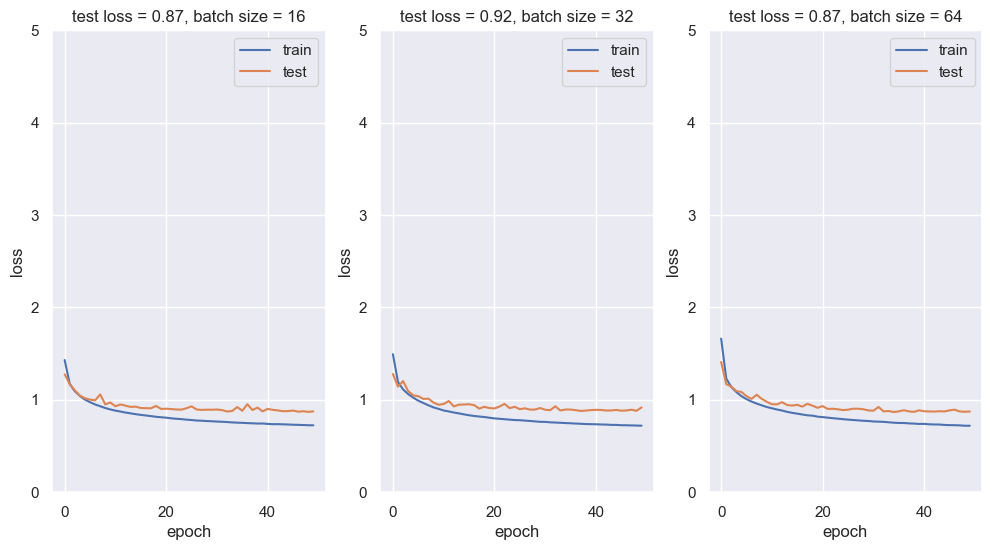

In [20]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list(x_train)).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=( np.array(list(x_test)).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 5))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()

From the loss plots above, a batch of size 16 seems to give the best performance.

A [_ModelCheckpoint callback_](https://keras.io/api/callbacks/) is used to save the best model/weights (in a checkpoint file) at some interval, so the model/weights can either be saved as it or be loaded later to continue the training from the state saved.

Now, we train the model with a batch size of 16 (because as seen from the figure above, it has the lowest test loss) and we save the weights that give the best perfomance in the file `best_weights.weights.h5`.

The next cell fits the model again with batch size 16 and saves the model as a checkpoint.

In [21]:
# Save the trained model
filepath = DATA / "best_weights.weights.h5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]


# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

### Evaluation & prediction on test set

The [evaluate()](https://keras.io/api/models/model_training_apis/#evaluate-method) method is used to check the performance of our model. It reports the **loss** (which is the mse in our case) as well as evaluation metrics (which are the **mse** and **mae**).

The next cell uses the internal Keras method to evaluate the trained model with the test set.

In [22]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

Evaluate the model on the test data
 loss: 0.88
 mse (same as loss): 0.73
 mae: 0.88


The mean absolute error on the test set is as below $1.0$ which given the range of pIC50 values is pretty low.

We now predict the pIC50 values on the test data. 

The next cell predicts the pIC50 values of the test set and prints the 5 first predicte values.

In [23]:
# Predict pIC50 values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

1680/1680 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step
7.40
6.99
6.51
7.21
6.54


#### Scatter plot

To visualize the predictions, we plot the predicted vs. the true pIC50 values on the test set. 

The next cell plots all the predicted values against the actual values.

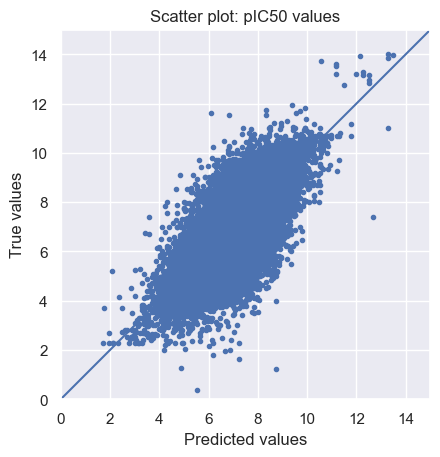

In [24]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()

As we can see, there is a positive linear relation between the predicted and true values, but the fit is far from perfect.